In [57]:
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import re
import unidecode
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
dates = tuple((f'01/01/{year}', f'31/12/{year}') for year in range(2000, 2027))
dates = (('10/10/2000', dates[0][1]),) + dates[1:]
scraped_dates = dates[:13]
df = pd.concat([pd.read_csv(f'{date[0][-4:]}.csv', encoding='utf-8') for date in scraped_dates])
df['Data'] = df['Data'].str.split('-').str[::-1].str.join('/')
df = df[df['Hora'] != '*']
df['Data'] = pd.to_datetime(df['Data'] + ' ' + df['Hora'], format='%d/%m/%Y %Hh%M')
df = df.set_index('Data')
df.drop(['Hora'], axis=1, inplace=True)
df = df[df['Orador'].str.contains(",")]
df['Partido'] = df['Orador'].str.split(',').str[1]
df['Orador'] = df['Orador'].str.split(',').str[0]
df['Estado'] = df['Partido'].str.split('-').str[1]
df['Partido'] = df['Partido'].str.split('-').str[0]
df['Partido'] = df['Partido'].str.strip()
df['Discurso_Original'] = df['Discurso']
#drop partido longer than 6 characters
df = df[df['Partido'].str.len() < 7]

In [59]:
df = df.dropna(subset=['Discurso'])

In [60]:
coop_terms = [
    'cooperativa',
    'cooperativismo',
    'cooperativista',
    'cooperativistas',
    'cooperados',
    'OCB',
    'OCB/SESCOOP',
    'SESCOOP',
    'sistema ocb',
    'cooperativas',
    'coops',
]

In [61]:
# filter df for rows where any of the terms in coop_terms are present in 'discurso' row
df = df[df['Discurso'].str.contains('|'.join(coop_terms), flags=re.IGNORECASE)]
len(df)

4331

In [62]:
df.head()

,Sessão,Fase,URL_Discurso,Discurso,Orador,Publicação,Partido,Estado,Discurso_Original
Data,,,,,,,,,
2000-10-17 17:10:00,184.2.51.O,GRANDE EXPEDIENTE,https://www.camara.leg.br/internet/sitaqweb/Te...,O SR. ADÃO PRETTO (PT-RS. Pela ordem. Sem revi...,ADÃO PRETTO,DCD18/10/2000 PAG. 50993,PT,RS,O SR. ADÃO PRETTO (PT-RS. Pela ordem. Sem revi...
2000-10-20 11:42:00,187.2.51.O,GRANDE EXPEDIENTE,https://www.camara.leg.br/internet/sitaqweb/Te...,O SR. DAMIÃO FELICIANO (Bloco/PMDB-PB. Sem rev...,DAMIÃO FELICIANO,DCD21/10/2000 PAG. 52480,PMDB,PB,O SR. DAMIÃO FELICIANO (Bloco/PMDB-PB. Sem rev...
2000-10-23 16:36:00,188.2.51.O,COMUNICAÇÕES PARLAMENTARES,https://www.camara.leg.br/internet/sitaqweb/Te...,O SR. NILSON MOURÃO (PT-AC. Sem revisão do ora...,NILSON MOURÃO,DCD24/10/2000 PAG. 52605,PT,AC,O SR. NILSON MOURÃO (PT-AC. Sem revisão do ora...
2000-10-24 14:30:00,189.2.51.O,PEQUENO EXPEDIENTE,https://www.camara.leg.br/internet/sitaqweb/Te...,O SR. THEMÍSTOCLES SAMPAIO (Bloco/PMDB-PI. Pro...,THEMÍSTOCLES SAMPAIO,DCD25/10/2000 PAG. 52751,PMDB,PI,O SR. THEMÍSTOCLES SAMPAIO (Bloco/PMDB-PI. Pro...
2000-10-30 14:54:00,192.2.51.O,PEQUENO EXPEDIENTE,https://www.camara.leg.br/internet/sitaqweb/Te...,O SR. CONFÚCIO MOURA (Bloco/PMDB-RO. Pronuncia...,CONFÚCIO MOURA,DCD31/10/2000 PAG. 53251,PMDB,RO,O SR. CONFÚCIO MOURA (Bloco/PMDB-RO. Pronuncia...


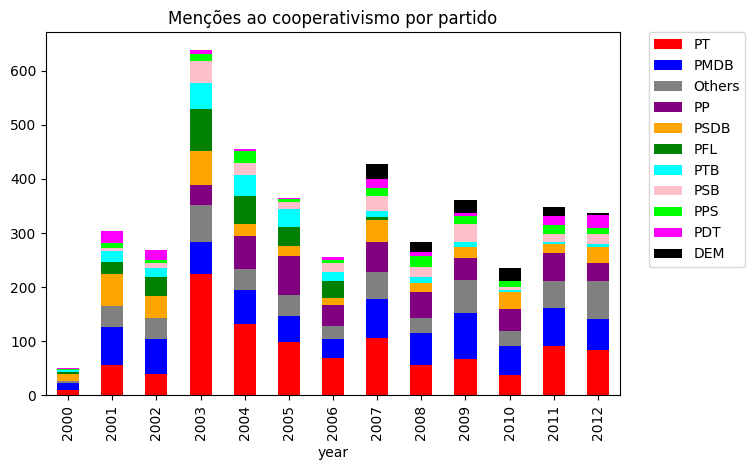

In [64]:

# Create a year column based on the index
df['year'] = df.index.year
grouped = df.groupby(['year', 'Partido']).size().unstack().fillna(0)

# Determine the top 10 parties based on total mentions across all years
top_parties = grouped.sum().nlargest(10).index.tolist()

# Any party not in the top 10 list will be relabeled as 'Others'
df['Partido_modified'] = df['Partido'].apply(lambda x: x if x in top_parties else 'Others')

# Regroup data based on the modified party column
grouped_modified = df.groupby(['year', 'Partido_modified']).size().unstack().fillna(0)

# Order the stratifications based on the total count of mentions
ordered_columns = grouped_modified.sum().sort_values(ascending=False).index.tolist()
grouped_modified = grouped_modified[ordered_columns]

# Explicit color mapping for specific parties
party_colors = {
    'PT': 'red',
    'PMDB': 'blue',
    'PFL': 'green',
    'PSDB': 'orange',
    'PP': 'purple',
    'PTB': 'cyan',
    'Others': 'grey',
    'PSB': 'pink',
    'PL': 'yellow',
    'PPB': 'brown',
    'PPS': 'lime',
    'PDT': 'magenta',
    'DEM': 'black',
    
}

colors = [party_colors[party] for party in ordered_columns]

# Plot
grouped_modified.plot(kind='bar', stacked=True, color=colors)
plt.title('Menções ao cooperativismo por partido')
plt.tight_layout()

# Place legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
